# Scrape and Analyse Amazon Reviews

In [1]:
import os
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from lxml import html
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import safe_get_stop_words
from wordcloud import WordCloud

In [2]:
def scrape_reviews(asins):
    ratings_dict = {}
    reviews_list = []
    reviews_df = pd.DataFrame()

    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
    XPATH_REVIEWS = '//div[@data-hook="review"]'
    XPATH_REVIEW_RATING = './/i[@data-hook="review-star-rating"]//text()'
    XPATH_REVIEW_HEADER = './/a[@data-hook="review-title"]//text()'
    XPATH_REVIEW_AUTHOR = './/a[@data-hook="review-author"]//text()'
    XPATH_REVIEW_DATE = './/span[@data-hook="review-date"]//text()'
    XPATH_REVIEW_BODY = './/span[@data-hook="review-body"]//text()'
    XPATH_REVIEW_HELPFUL = './/span[@data-hook="helpful-vote-statement"]//text()'

    p_num = 0
    for asin in asins:
        while True:
            print 'Scraping review page nr. {}'.format(p_num)
            amazon_url = 'https://www.amazon.com/product-reviews/' + asin + '?pageNumber=' + str(p_num) + '&sortBy=recent'
            # Add some recent user agent to prevent amazon from blocking the request 
            # Find some chrome user agent strings  here https://udger.com/resources/ua-list/browser-detail?browser=Chrome
            page = requests.get(amazon_url, headers=headers)
            page_response = page.text.encode('utf-8')

            parser = html.fromstring(page_response)

            reviews = parser.xpath(XPATH_REVIEWS)
            if not len(reviews) > 0:
                break
            # Parsing individual reviews
            for review in reviews:
                raw_review_author = review.xpath(XPATH_REVIEW_AUTHOR)
                raw_review_rating = review.xpath(XPATH_REVIEW_RATING)
                raw_review_header = review.xpath(XPATH_REVIEW_HEADER)
                raw_review_date = review.xpath(XPATH_REVIEW_DATE)
                raw_review_body = review.xpath(XPATH_REVIEW_BODY)
                raw_review_helpful = review.xpath(XPATH_REVIEW_HELPFUL)

                review_dict = {
                    'review_text': raw_review_body,
                    'review_posted_date': raw_review_date,
                    'review_header': raw_review_header,
                    'review_rating': raw_review_rating,
                    'review_helpful': raw_review_helpful,
                    'review_author': raw_review_author
                }
                reviews_df = reviews_df.append(review_dict, ignore_index=True)
            p_num += 1
            if p_num > 7:
                break
    return reviews_df

## Scrape or load reviews

In [3]:
filename = 'echo_dot_reviews.pickle'
asins = ['B01DFKC2SO']

if os.path.isfile(filename):
    print 'Loading reviews from disk'
    reviews_df = pd.read_pickle(filename)
    print 'Loaded {} reviews'.format(len(reviews_df))
else:
    print 'Scraping reviews'
    reviews_df = scrape_reviews(asins)
    print 'Scraped {} reviews'.format(len(reviews_df))
    print 'Saving reviews to disk'
    reviews_df.to_pickle(filename)

Loading reviews from disk
Loaded 46298 reviews


## Data cleaning and preprocessing

In [4]:
for col in reviews_df.columns:
    reviews_df[col] = reviews_df[col].apply(lambda x: '\n'.join(x))

reviews_df['review_helpful'] = (reviews_df['review_helpful']
                                .str.replace('One', '1')
                                .str.replace(r'[^0-9]', ''))
reviews_df['review_helpful'].loc[reviews_df['review_helpful'] == ''] = '0'
reviews_df['review_helpful'] = reviews_df['review_helpful'].astype(int)

reviews_df['review_posted_date'] = pd.to_datetime(reviews_df['review_posted_date']
                                                  .str.strip('on'))

reviews_df['review_rating'] = reviews_df['review_rating'].str.strip('out of 5 stars').astype(float)
reviews_df.loc[reviews_df['review_rating'] == 0, 'review_rating'] = 5

reviews_df['review_length'] = reviews_df['review_text'].apply(lambda x: len(x))

reviews_df.drop_duplicates(inplace=True)

## Histogram of Reviews' Lengths

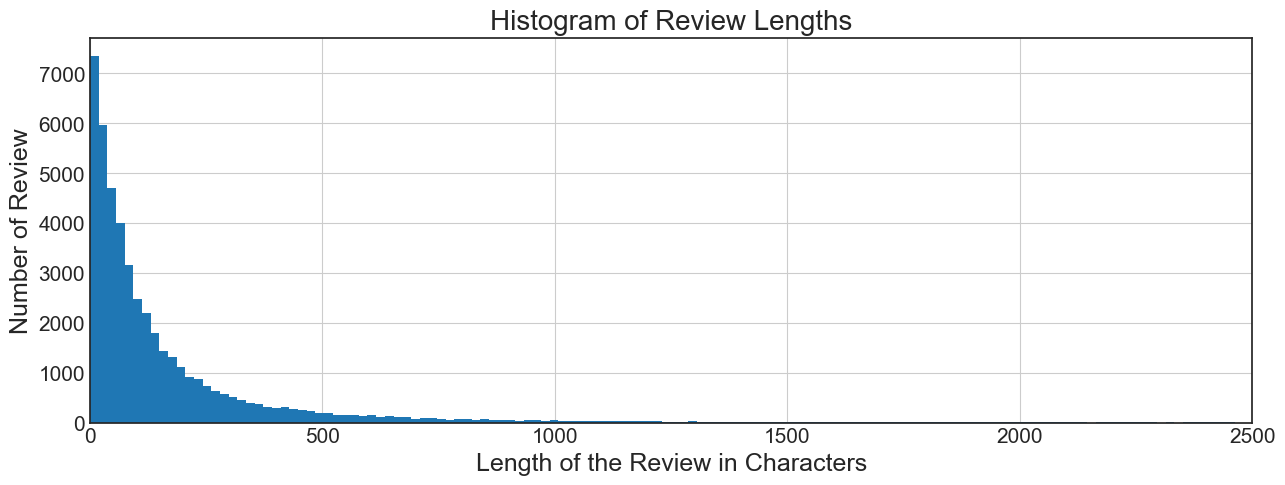

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 5))
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)

axes = reviews_df['review_length'].hist(bins=1000)
axes.set_xlim(0, 2500)
plt.title('Histogram of Review Lengths', fontsize=20)
plt.xlabel('Length of the Review in Characters', fontsize=18)
plt.ylabel('Number of Review', fontsize=18)
plt.show()

## Histogram of Logarithm of Reviews' Lengths in Characters

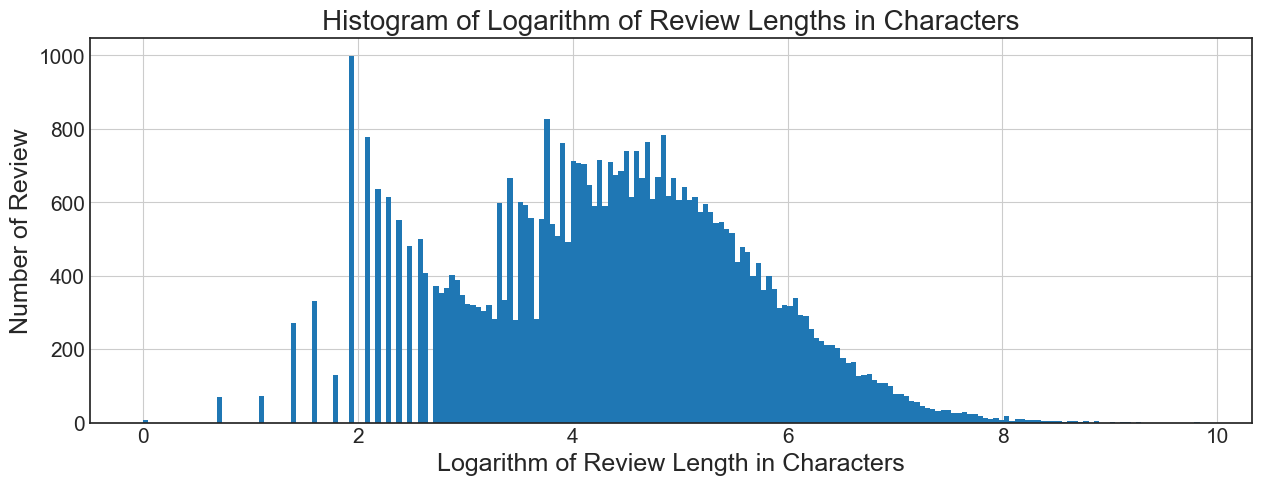

In [6]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 5))
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
axes = np.log(reviews_df['review_length'].loc[reviews_df['review_length'] > 0]).hist(bins=200)
plt.title('Histogram of Logarithm of Review Lengths in Characters', fontsize=20)
plt.xlabel('Logarithm of Review Length in Characters', fontsize=18)
plt.ylabel('Number of Review', fontsize=18)
plt.show()

## Mode of Review Lengths

In [7]:
reviews_df['review_length'].mode()

0    7
dtype: int64

## Histogram of Ratings

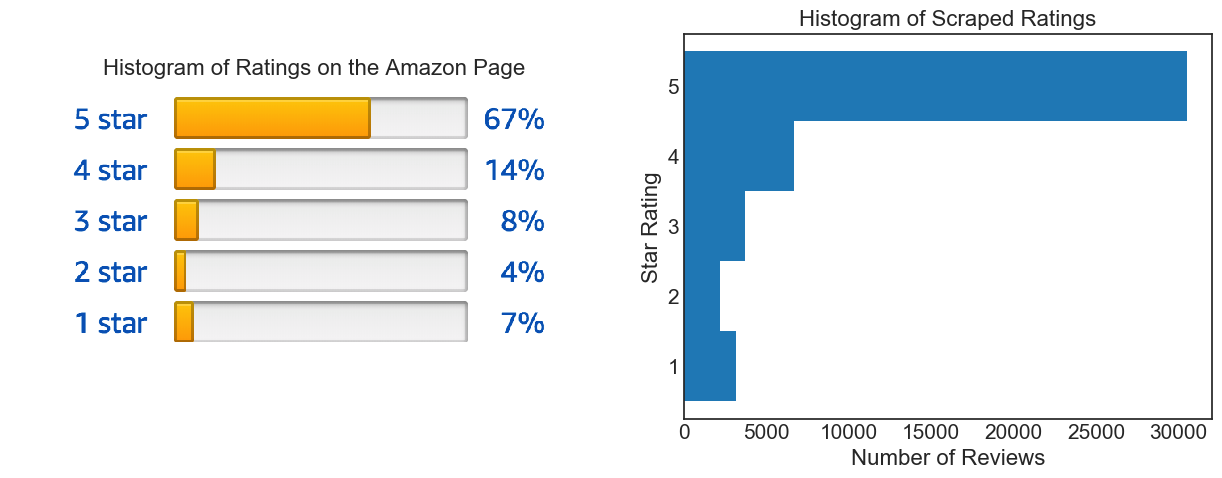

In [8]:
plt.style.use('seaborn-white')

fig = plt.figure()
fig.set_size_inches(15, 5)
a = fig.add_subplot(1, 2, 1)
img = mpimg.imread('amz_hist_ratings.png')
lum_img = img
imgplot = plt.imshow(lum_img)
plt.title('Histogram of Ratings on the Amazon Page', fontsize=16)

a.axis('off')
a = fig.add_subplot(1, 2, 2)

mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
a.hist(reviews_df['review_rating'], bins=np.arange(1, 7) - 0.5, orientation="horizontal")

plt.title('Histogram of Scraped Ratings', fontsize=16)
plt.ylabel('Star Rating', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=16)

plt.show()

## Histogram of Review Dates

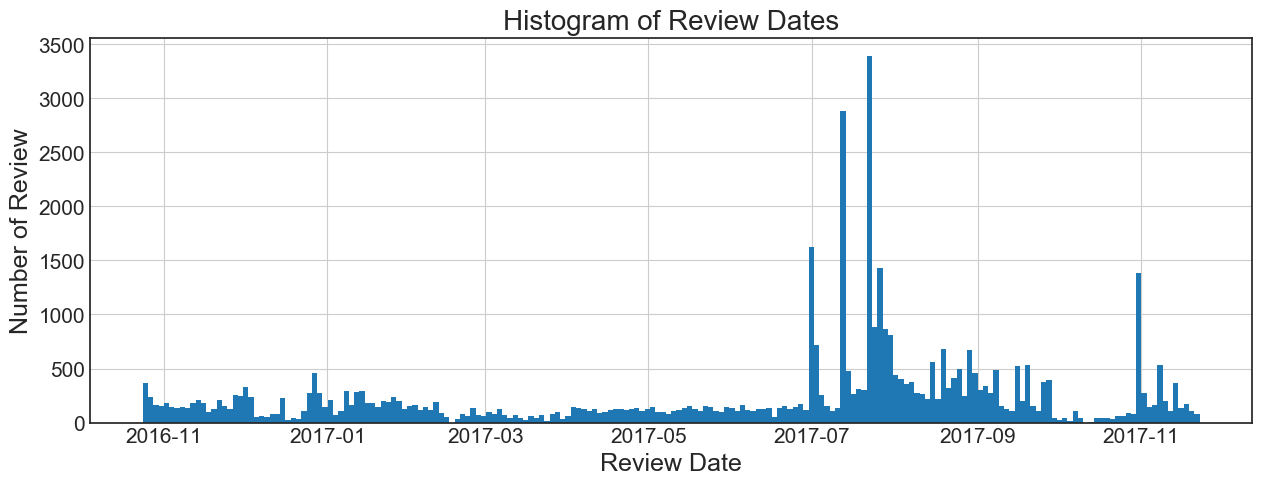

In [9]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 5))
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
axes = reviews_df['review_posted_date'].hist(bins=200)
plt.title('Histogram of Review Dates', fontsize=20)
plt.xlabel('Review Date', fontsize=18)
plt.ylabel('Number of Review', fontsize=18)
plt.show()

## Length of the review vs. the number of people who found it helpful

/Users/kiril/anaconda/envs/prezly/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


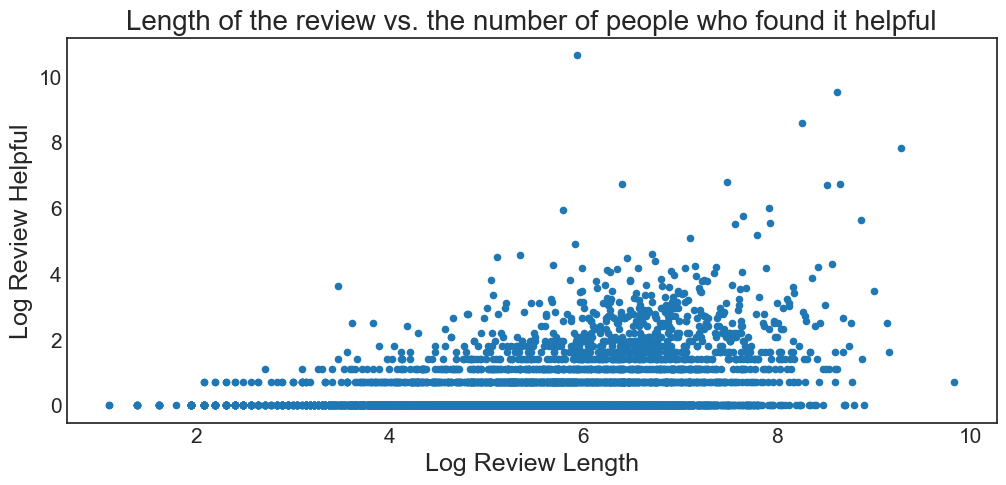

In [10]:
reviews_df['log_review_helpful'] = None
reviews_df['log_review_helpful'].loc[reviews_df['review_helpful'] > 0] = np.log(
    reviews_df['review_helpful'].loc[reviews_df['review_helpful'] > 0])
reviews_df['log_review_helpful'] = reviews_df['log_review_helpful'].astype(float)

reviews_df['log_review_length'] = None
reviews_df['log_review_length'].loc[reviews_df['review_length'] > 0] = np.log(
    reviews_df['review_length'].loc[reviews_df['review_length'] > 0])
reviews_df['log_review_length'] = reviews_df['log_review_length'].astype(float)

plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(12, 5)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
a = fig.add_subplot(1, 1, 1)
a = reviews_df.dropna(subset=['log_review_length', 'log_review_helpful']).plot.scatter('log_review_length',
                                                                                       'log_review_helpful', ax=a)

plt.title('Length of the review vs. the number of people who found it helpful', fontsize=20)
plt.xlabel('Log Review Length', fontsize=18)
plt.ylabel('Log Review Helpful', fontsize=18)
plt.show()

## Word clouds

In [11]:
def make_word_cloud(df, ngram_min, ngram_max):
    plt.style.use('seaborn-white')

    fig = plt.figure()
    fig.set_size_inches(15, 15)

    for ind, row in df.iterrows():
        data = row['review_text']
        min_df = int(max([min([9, 0.04 * len(data)]), 2]))
        num_words = 200
        ngram_range = (ngram_min, ngram_max)

        count_vectorizer = CountVectorizer(min_df=min_df,
                                           lowercase=True,
                                           stop_words=stop_words,
                                           ngram_range=ngram_range)
        counts = count_vectorizer.fit_transform(data)
        counts = counts.toarray().sum(axis=0)
        count_weighting = dict(zip(count_vectorizer.get_feature_names(), counts))
        count_weighting_df = pd.DataFrame.from_dict(count_weighting, orient='index')
        count_weighting_df = count_weighting_df.reset_index(drop=False)
        count_weighting_df.columns = ['word', 'count']

        count_weighting_df = count_weighting_df.sort_values(['count'], ascending=False)
        count_weighting_df = count_weighting_df.set_index('word')

        word_cloud_freq = count_weighting_df['count'].head(num_words).to_dict()
        wordcloud = WordCloud(collocations=False).generate_from_frequencies(word_cloud_freq)
        a = fig.add_subplot(1, 2, ind + 1)
        plt.title(str(row['rating_text']), fontsize=20)
        plt.imshow(wordcloud, cmap=plt.cm.bone, interpolation='bilinear')
        plt.axis("off")
    plt.show()

In [12]:
stop_words = safe_get_stop_words('en')
stop_words.extend(['amazon',
                   'alexa',
                   'echo',
                   'dot',
                   'can',
                   'just',
                   'work',
                   'music',
                   'one',
                   'get',
                   'will',
                   'time',
                   'speaker',
                   'use',
                   'app',
                   'google',
                   'home',
                   ])

reviews_df['rating_text'] = None
reviews_df['rating_text'].loc[reviews_df['review_rating'] < 4] = '1, 2 or 3 stars'
reviews_df['rating_text'].loc[reviews_df['review_rating'] >= 4] = '4 or 5 stars'
reviews_by_rating = reviews_df.groupby('rating_text')['review_text'].apply(list)
reviews_by_rating = reviews_by_rating.reset_index(drop=False)

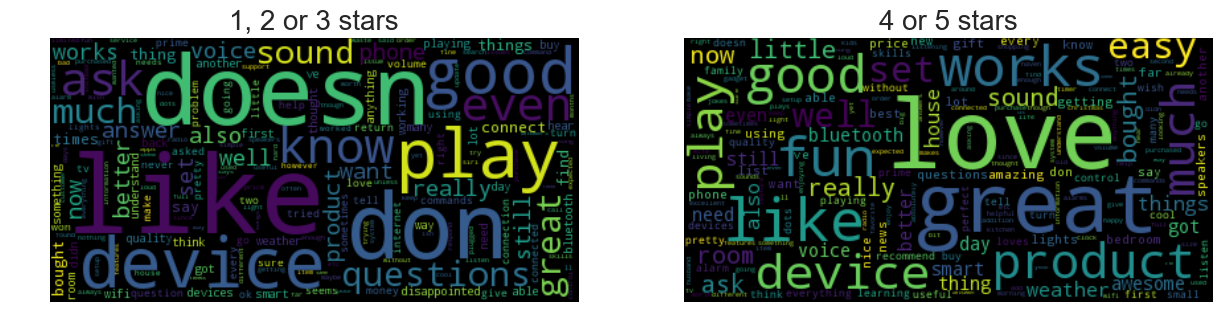

In [13]:
make_word_cloud(reviews_by_rating, 1, 1)

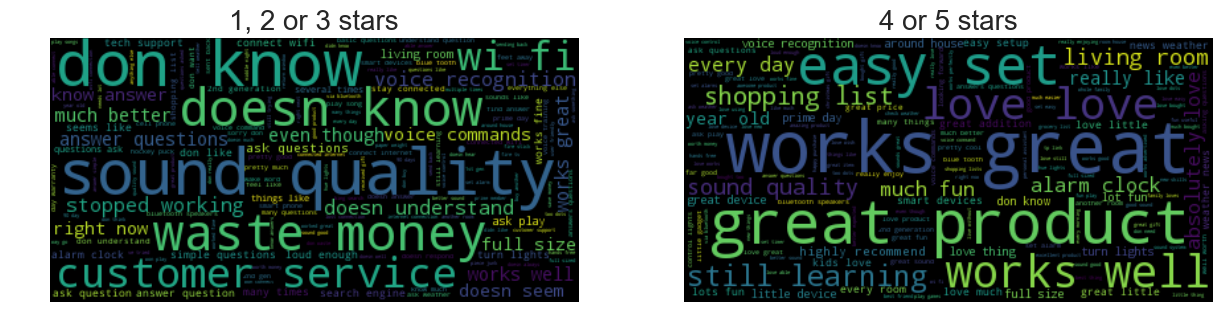

In [14]:
make_word_cloud(reviews_by_rating, 2, 2)

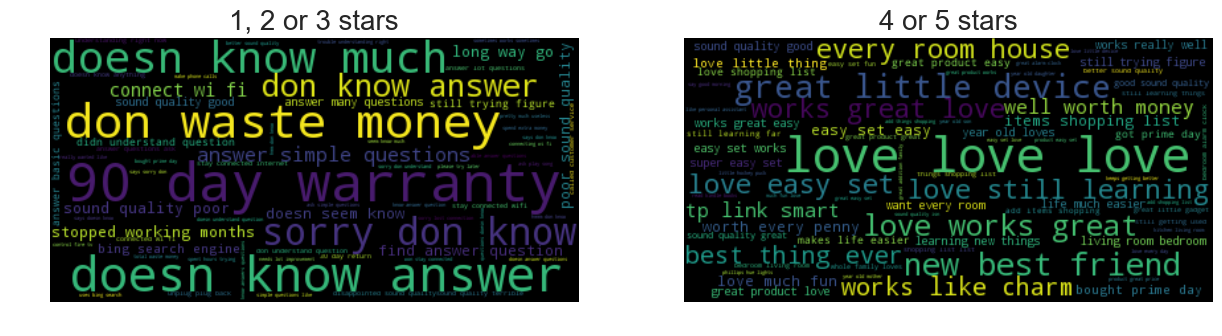

In [15]:
make_word_cloud(reviews_by_rating, 3, 3)